In [127]:
%matplotlib inline
import theano
floatX = theano.config.floatX
import pymc3 as pm
import theano.tensor as T
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')
sns.set_style('white')
import numpy as np
import income.util as util
from income.setup import setup

In [171]:
X_train, Y_train, X_test, Y_test = setup(training_data="data/income/2014.csv",test_data="data/income/2015.csv")
X_train_1, Y_train_1, X_test_1, Y_test_1 = setup(training_data="data/income/2013.csv",test_data="data/income/2015.csv")
print(X_train.shape)
print(Y_train.shape)

(8451, 4)
(8451, 1)


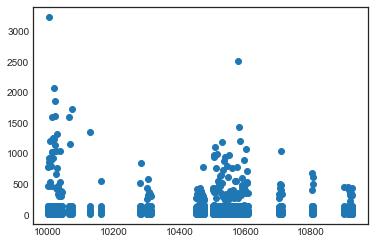

In [129]:
#Y_train['avg_total_income'] = Y_train['avg_total_income'].max()
plt.scatter(X_train['zipcode'].head(1000),Y_train['avg_total_income'].head(1000))

In [5]:
from sklearn.ensemble import RandomForestRegressor
rf_clf = RandomForestRegressor(max_depth=5, n_estimators=10, max_features=1)
rf_clf.fit(X_train, Y_train)
rf_clf.predict(X_test)

array([ 39.08673072])

In [143]:
def construct_nn(ann_input, ann_output):
    n_hidden = 5

    numFeatures = ann_input.get_value().shape[1];

    init_in_1 = np.random.randn(numFeatures, n_hidden).astype(floatX)
    init_1_2 = np.random.randn(n_hidden, n_hidden).astype(floatX)
    init_2_out = np.random.randn(n_hidden).astype(floatX)

    with pm.Model() as neural_network:
        weights_in_1 = pm.Normal('w_in_1', 0, sd=1,
                                 shape=(numFeatures, n_hidden), testval=init_in_1)
        weights_1_2 = pm.Normal('w_1_2', 0, sd=1,
                                shape=(n_hidden, n_hidden), testval=init_1_2)
        weights_2_out = pm.Normal('w_2_out', 0, sd=1,
                                  shape=(n_hidden,), testval=init_2_out)

        act_1 = pm.math.tanh(pm.math.dot(ann_input, weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1, weights_1_2))
        act_3 = pm.math.sigmoid(pm.math.dot(act_2, weights_2_out))

        a = pm.Uniform('uni_1', lower=0, upper=5000)
        act_4 = pm.Deterministic('det_1', a * act_3)
        act_out = pm.HalfNormal('half_norm_1', act_4, observed=ann_output)

        out = pm.Normal('out', act_out, observed=ann_output)

    return neural_network

ann_input = theano.shared(np.array(X_train))
ann_output = theano.shared(np.array(Y_train['avg_total_income']))
neural_network = construct_nn(ann_input, ann_output)

In [144]:
from pymc3.theanof import set_tt_rng, MRG_RandomStreams
set_tt_rng(MRG_RandomStreams(42))

%time
with neural_network:
    inference = pm.ADVI()
    approx = pm.fit(n=3000, method=inference)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


Average Loss = 69,617: 100%|██████████| 3000/3000 [00:14<00:00, 209.88it/s]
Finished [100%]: Average Loss = 69,625


In [145]:
trace = approx.sample(draws=5000)

In [146]:
approx

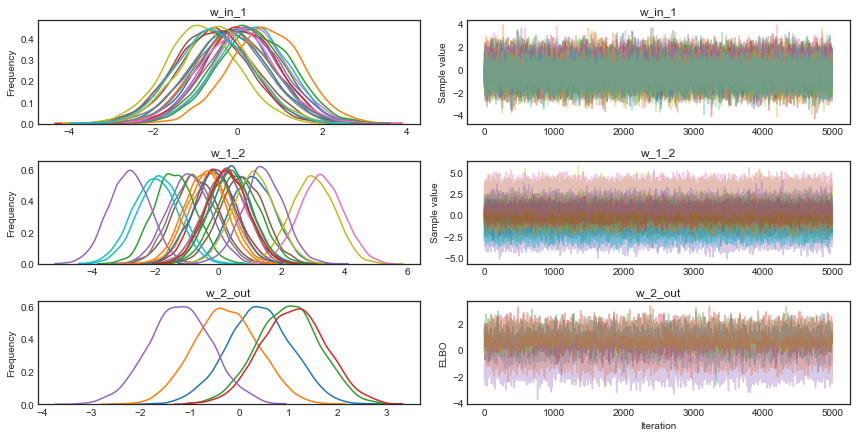

In [54]:
#plt.plot(-inference.hist, label='new ADVI', color='b', alpha=0.3)
pm.traceplot(trace)
plt.ylabel('ELBO')
plt.xlabel('Iteration')
plt.legend()

100%|██████████| 500/500 [00:15<00:00, 32.29it/s]


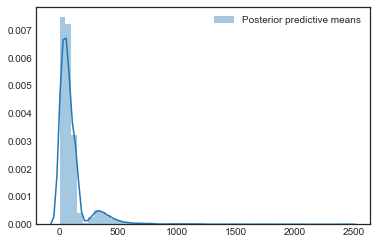

In [147]:
ann_input.set_value(X_test)
#ann_output.set_value(Y_test['avg_total_income'])

with neural_network:    
    ppc = pm.sample_ppc(trace, 500)
    pred = ppc['out'].mean(axis=0)
    proba = ppc['out'].std(axis=0)

plt.figure()
ax = sns.distplot(ppc['out'][0], label='Posterior predictive means')
#ax.axvline(Y_train.mean(), color='r', ls='--', label='True mean')
ax.legend()
#print('Accuracy: {}'.format( Y_test - ppc['out'])

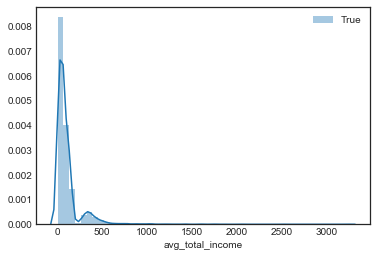

In [140]:
plt.figure()
ax = sns.distplot(Y_train['avg_total_income'], label='True')
ax.legend()

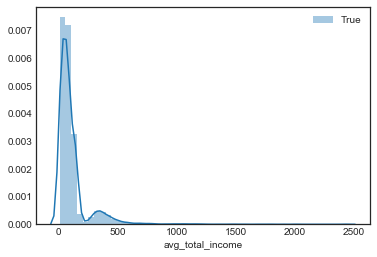

In [149]:
plt.figure()
ax = sns.distplot(Y_test['avg_total_income'], label='True')
ax.legend()

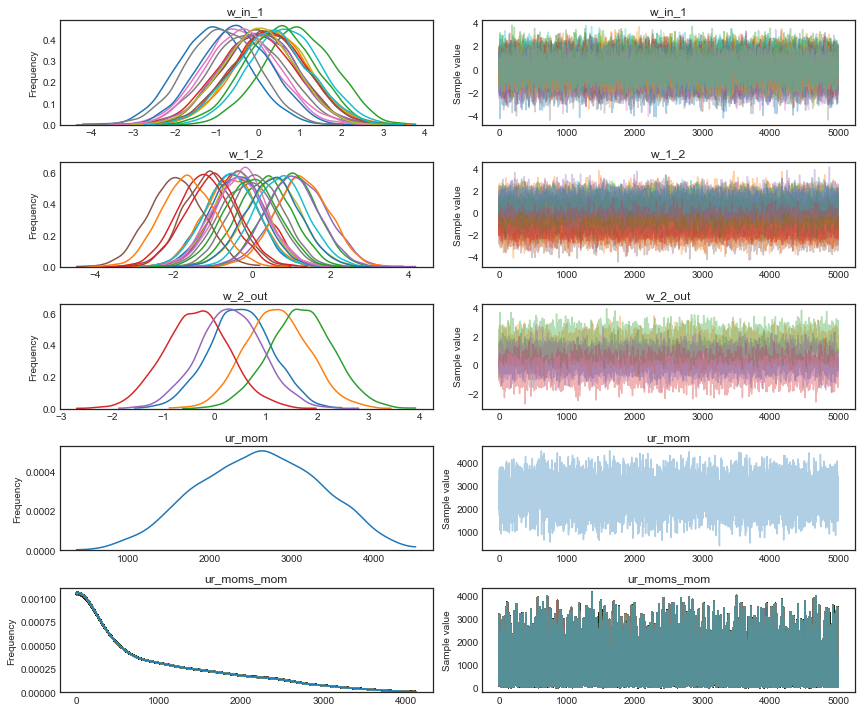

In [87]:
with neural_network:
    pm.traceplot(trace)

In [148]:
# from sklearn.metrics import mean_squared_error
# print(mean_squared_error(Y_test['avg_total_income'], pred))
number_correct = sum((abs(Y_test['avg_total_income'] - pred) < 0.1))/len(Y_test)
print('Accuracy: {}'.format( number_correct ))

Accuracy: 0.9756788665879575


In [169]:
#ax.errorbar(X_test["zipcode"], y=pred, yerr=proba)
#X_train.shape
ppc['out'].shape

(500, 8470)

In [108]:
grid = pm.floatX(np.mgrid[-3:3:100j, -3:3:100j])
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)
ppc = sample_proba(grid_2d, 500)

NameError: name 'sample_proba' is not defined

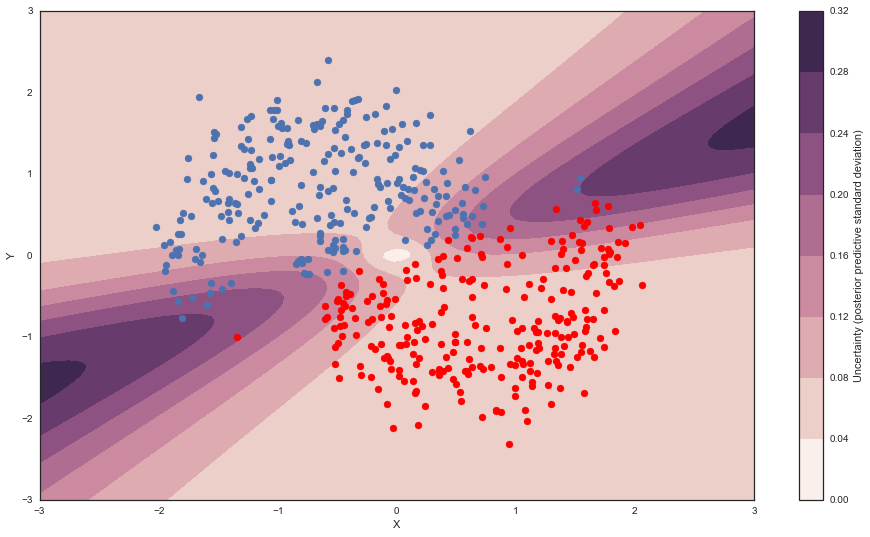

In [37]:
#Now the true power of Probabilistic Net
#Look at the standard deviations of the predictions
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], ppc.std(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y')
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)')

In [38]:
#Use minibatch
minibatch_x = pm.Minibatch(X_train, batch_size=50)
minibatch_y = pm.Minibatch(Y_train, batch_size=50)
neural_net_minbatch = construct_nn(minibatch_x, minibatch_y)
with neural_net_minbatch:
    approx = pm.fit(40000, method=pm.ADVI())

Average Loss = 153.34: 100%|██████████| 40000/40000 [00:06<00:00, 6201.24it/s]
Finished [100%]: Average Loss = 153.28


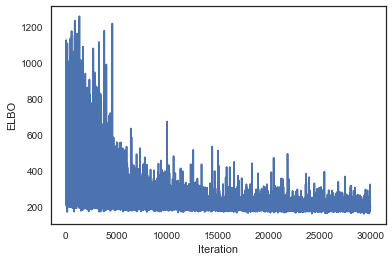

In [39]:
plt.plot(inference.hist)
plt.ylabel('ELBO'); plt.xlabel('Iteration')